In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import patheffects
import importlib
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

import plot
importlib.reload(plot)
visualize = plot.visualize
parse_logs = plot.parse_logs


     shrink      grow     touch    touch2  iter                 mode   install
1  1.057603  0.426887  1.031537  0.067895     1       virtio-balloon  1.458424
2  1.050183  0.427368  1.016332  0.125305     2       virtio-balloon  1.443701
3  1.043587  0.427922  1.047265  0.129761     3       virtio-balloon  1.475188
4  1.035610  0.426925  1.045430  0.068682     4       virtio-balloon  1.472355
5  1.061880  0.427211  1.019740  0.095158     5       virtio-balloon  1.446951
6  1.047812  0.425725  1.012924  0.146276     6       virtio-balloon  1.438649
7  1.054956  0.425992  1.043071  0.082051     7       virtio-balloon  1.469063
8  1.048790  0.425588  1.014235  0.126353     8       virtio-balloon  1.439823
9  1.059253  0.425669  1.043071  0.070779     9       virtio-balloon  1.468739
1  0.007077  0.003051  0.233570  0.058458     1  virtio-balloon-huge  0.236622
2  0.007429  0.003076  0.231735  0.058720     2  virtio-balloon-huge  0.234811
3  0.007572  0.003074  0.235143  0.058196     3  vir

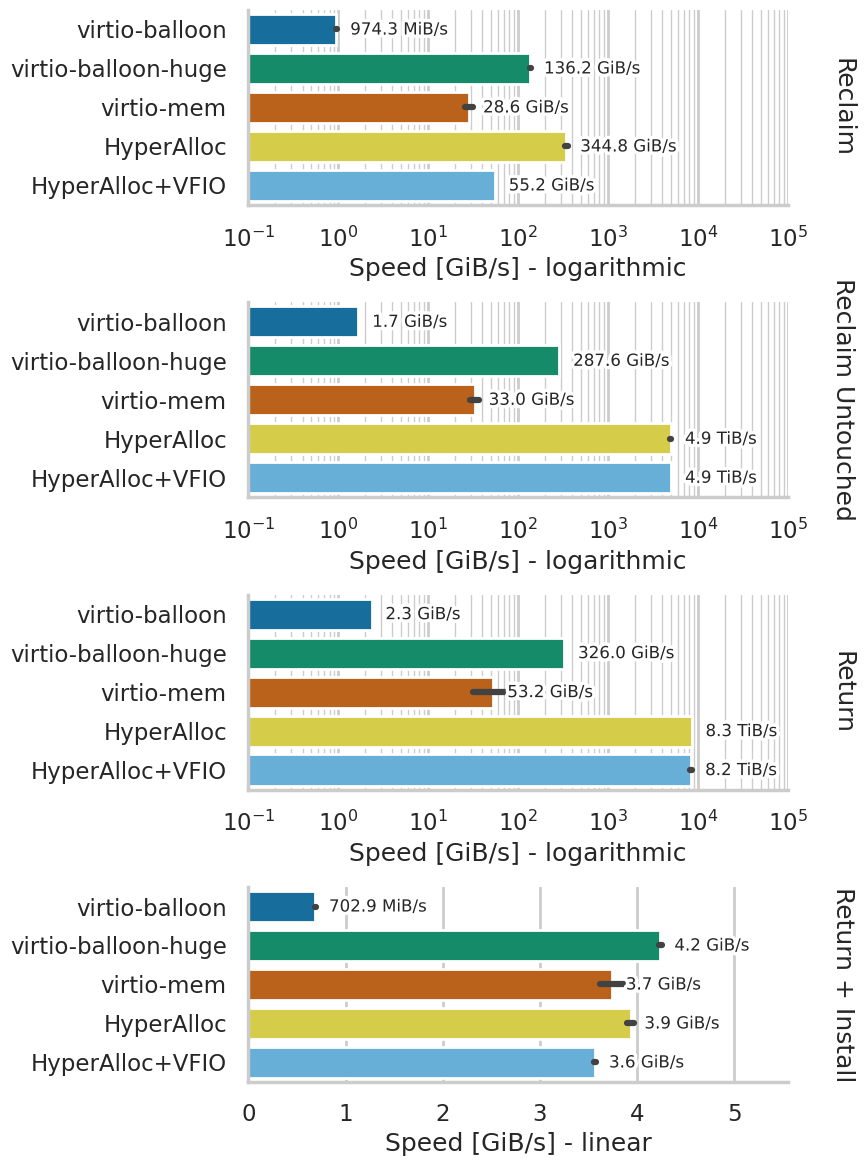

In [8]:
visualize(
    [
        Path("latest/base-manual"),
        Path("latest/huge-manual"),
        Path("latest/virtio-mem-movable"),
        Path("latest/virtio-mem-movable-vfio"),
        Path("latest/llfree-manual"),
        Path("latest/llfree-manual-vfio"),
    ],
    [
        Path("latest/nofault-base-manual"),
        Path("latest/nofault-huge-manual"),
        Path("latest/nofault-virtio-mem-movable"),
        Path("latest/nofault-virtio-mem-movable-vfio"),
        Path("latest/nofault-llfree-manual"),
        Path("latest/nofault-llfree-manual-vfio"),
    ],
    save_as="inflate",
)

     shrink      grow     touch      touch2  iter                 mode  \
1  1.057603  0.426887  1.031537  1290010624     1       virtio-balloon   
2  1.050183  0.427368  1.016332  2380791808     2       virtio-balloon   
3  1.043587  0.427922  1.047265  2465464320     3       virtio-balloon   
4  1.035610  0.426925  1.045430  1304952832     4       virtio-balloon   
5  1.061880  0.427211  1.019740  1808007168     5       virtio-balloon   
6  1.047812  0.425725  1.012924  2779250688     6       virtio-balloon   
7  1.054956  0.425992  1.043071  1558970368     7       virtio-balloon   
8  1.048790  0.425588  1.014235  2400714752     8       virtio-balloon   
9  1.059253  0.425669  1.043071  1344798720     9       virtio-balloon   
1  0.007077  0.003051  0.233570  1110704128     1  virtio-balloon-huge   
2  0.007429  0.003076  0.231735  1115684864     2  virtio-balloon-huge   
3  0.007572  0.003074  0.235143  1105723392     3  virtio-balloon-huge   
4  0.007203  0.003074  0.232522  11107

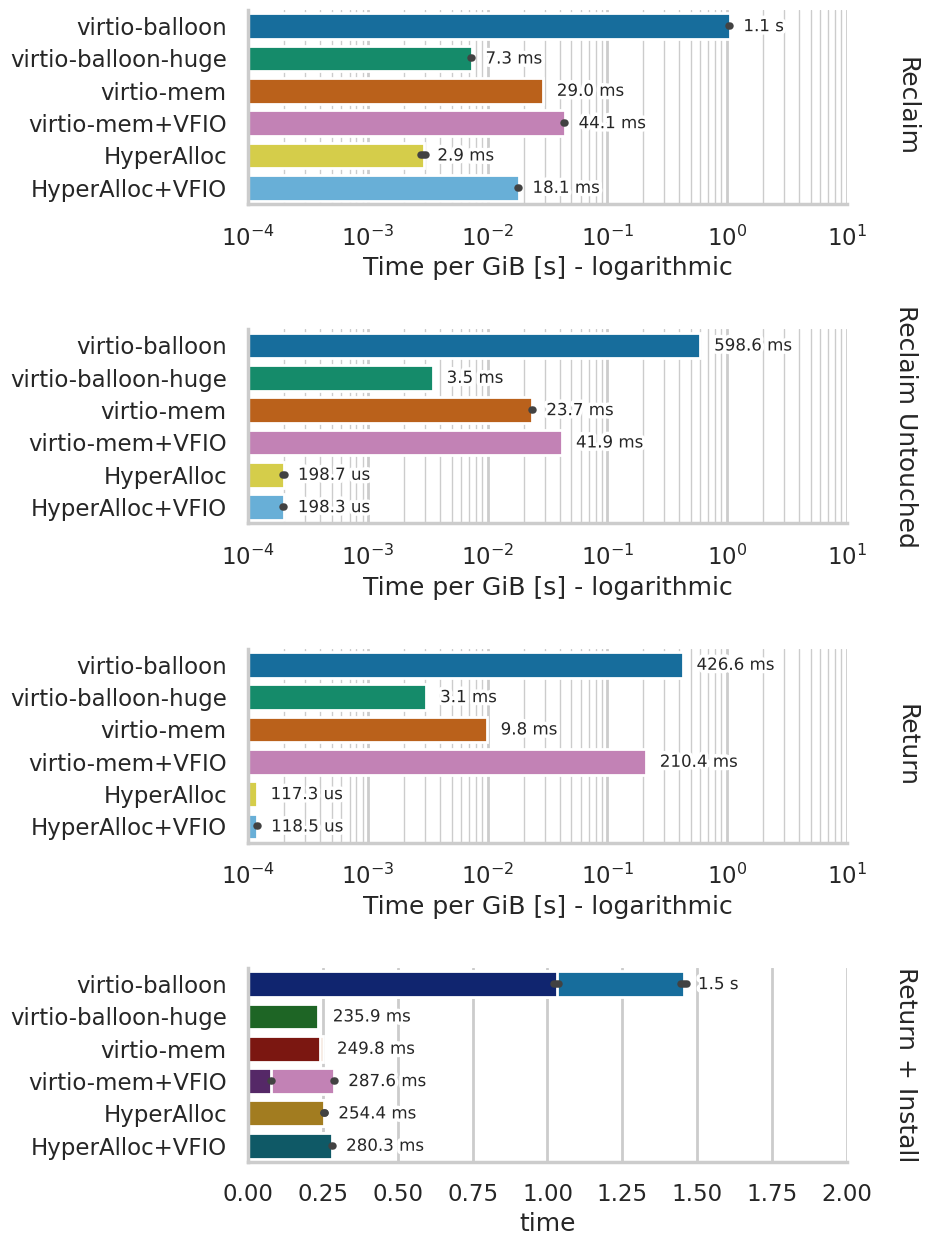

In [27]:
# Touched
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
data["install"] = data["touch"] + data["grow"]
print(data)

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow", "touch", "install"],
                var_name="op", value_name="time")
# pgd["time"] = 1 / pgd["time"]

# Untouched
paths = [
    Path("inflate/latest-nofault-base-manual"),
    Path("inflate/latest-nofault-huge-manual"),
    Path("inflate/latest-nofault-virtio-mem-movable"),
    Path("inflate/latest-nofault-virtio-mem-movable-vfio"),
    Path("inflate/latest-nofault-llfree-manual"),
    Path("inflate/latest-nofault-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
print(data)

pgd1 = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
# pgd1["time"] = 1 / pgd1["time"]
pgd1 = pgd1[pgd1["op"] == "shrink"]
pgd1["op"] = "Reclaim Untouched"

# Both
pgd = pd.concat([pgd, pgd1])
pgd.loc[pgd["op"] == "shrink", "op"] = "Reclaim"
pgd.loc[pgd["op"] == "grow", "op"] = "Return"
pgd.loc[pgd["op"] == "install", "op"] = "Return + Install"
pgd.loc[pgd["op"] == "touch", "op"] = "Install"
print(pgd["op"].unique())

print(pgd["time"].max())
order = ["virtio-balloon","virtio-balloon-huge","virtio-mem","virtio-mem+VFIO","HyperAlloc","HyperAlloc+VFIO"]
p = sns.FacetGrid(pgd, row="op", margin_titles=True,
                  row_order=["Reclaim", "Reclaim Untouched", "Return", "Return + Install"],
                  aspect=3, height=3.2, sharex=False)

p.map_dataframe(sns.barplot, y="mode", hue="mode", hue_order=order,
                palette="colorblind6", x="time", dodge=False)
p.set(ylabel=None)

def mem_fmt(x: float) -> str:
    x *= 1e9
    sizes = ["s", "ms", "us"]
    for i, suffix in enumerate(sizes):
        mul = 1e3 ** (len(sizes) - i)
        if x > mul: return f"{x/mul:.1f} {suffix}"
    return f"{x:.2} ns"

for key, ax in p.axes_dict.items():
    ax.grid(True, which="minor", linewidth=1)
    for c in ax.containers:
        ax.bar_label(c, fmt=mem_fmt, fontsize=12, padding=10,
                     path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])
    if key != "Return + Install":
        ax.set(xlim=(1e-4, 10))
        ax.set_xscale("log", base=10)
        ax.set(xlabel="Time per GiB [s] - logarithmic")
    else:
        ax.set(xlim=(0, 2))
        ax.set(xlabel="Time per GiB [s] - linear")
        sns.barplot(pgd[pgd["op"] == "Install"], ax=ax, y="mode", hue="mode", hue_order=order,
                palette="dark6", x="time", dodge=False)
        ax.set(ylabel=None)
        ax.get_legend().remove()

p.set_titles(row_template="{row_name}", xytext=(1.08, 0.5))
# p.figure.savefig("inflate/inflate.pdf", bbox_inches="tight")
# p.figure.savefig("inflate/inflate.svg", bbox_inches="tight")
# dref_dataframe("inflate", Path("inflate"), ["mode", "iter", "op"], pgd)